# Exercise 1 for the class EE-568 Theory and Methods of Reinforcement Learning taught at EPFL in Spring 2024 by Prof. Volkan Cevher

In [1]:
import os
from typing import List

import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import sys

sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from plot import plot_log_lines, plot_lines

%load_ext autoreload
%autoreload 2

# Dynamic Programming exercise

We will make use of the operators introduced in the slides of lectures 1 and 2. 
$(T V)(s)$, $\mathcal{G}$ and $T^{\pi}$

Before diving into the implementation of Value Iteration or Policy Iteration, we instantiate an environment using the library in the foilder `src`.

The gridworld environment is instantiated via the class `GridWorldEnvironment`. It takes 4 input values:

- `reward_mode` : integer between 0 and 3 for different reward profiles
- `size`: Gridworld size
- `prop`: probability assigned to the event that the agent do not follow the chosen action but another one selected uniformely at random.
- `gamma`: the discount factor of the environment.

In [2]:
reward_mode = 2  # put an image to show which is the reward
size = 10
prop = 0
gamma = 0.99  # rename discount_factor
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

Below, we illustrate how to access the gridworld environment, i.e. how to access the reward, the transition matrix and the discount factor.

In [3]:
size = 3
gridworld_example = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

***Interface with a Gridworld instance***
- `print(gridworld.n_states)` #return the number of states
- `print(gridworld.n_actions)` #return the number of actions
- `print(gridworld.r)` #return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` #Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.



<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

Then we set up the solver object that will implement the routine needed to evaluate the value of the produced policies

In [4]:
solver = MDPsolver(gridworld)

We will use this solver to compute the optimal value function to measure the suboptimality of the policies produced by value iteration or policy iteration.

To access the optimal value function use `solver.v`.

In [5]:
solver.value_iteration()
# print(solver.v)

## Ex 1: Value Iteration [25 pts.]


### 1.1 Implement value iteration (Done)

In [6]:
def value_iteration(env, tol=1e-10):
    """Inplementation of value iteration, note that the implementation is based on value iteration mentioned in the lecture.
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        policies: policy  at each iteration (list)
        vs: value functions at each iteration (list)
    """
    policies = []
    vs = []
    v = np.zeros(env.n_states) # initialize value function
    q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
    
    while True:
        v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
        for a in range(env.n_actions):
            #reward = env.r[:, a]  # Get immediate rewards for all states taking action `a`
            # Transition probability matrix for action `a`
            P_a = env.sparseT[a].toarray()  # Shape: (n_states, n_states)
             # Compute expected future Q-values using matrix multiplication
            expected_future_q = np.dot(P_a,np.max(q, axis=1)) # Matrix-vector product
            q[:, a] = env.r[:, a] + env.gamma*expected_future_q # calculate Q-value
        v = np.max(q,axis=1) # update value function
        policies.append(np.argmax(q,axis=1)) # obtain policy
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol: # convergence criterion
            break
    return policies, vs

In [7]:
policies, vs = value_iteration(gridworld)

### 1.2: Evaluate the extracted policies (Done)

For the evaluation of the sequence of policies, i.e. computing $V^\pi$ for each policy $\pi$ we recall that $V^\pi$ is the fixed point $V^\pi = T^\pi (V^\pi)$.
In the following code, we ask you to apply the operator $T^\pi$ a number of time sufficient to find a value $V$ such that $ || T^\pi(V) - V || \leq \mathrm{tol}$

In [8]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    """Inplementation of policy evaluation through iteratively applying policy value iteration 
    Args:
        policies: a list of policies obtained by section 1.1
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        values: a list of value function for each policy
    """
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                #reward = env.r[:, a]  # Get immediate rewards for all states taking action `a`
                # Transition probability matrix for action `a`
                P_a = env.sparseT[a].toarray()  # Shape: (n_states, n_states)
                
                q[:, a] = env.r[:, a] + env.gamma * np.dot(P_a,v) #calculate Q-value
            for s in range(env.n_states):
                action_taken = pi[s] # obtain the action determined by the policy
                v[s] = q[s,action_taken] #calculate value function by $v(s) = Q(s,pi(s))$
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [9]:
values = evaluate_policy_sequence(policies, gridworld)

### 1.3: Plot the results (Done)

Plot using the method ```plot_lines(list_to_plot, list_name, axis_label, folder, title, x_axis = None, show = False) ```

Compute both the iterates $V_t$ produced by value iteration and the value function achieved by the extracted policies $V^{\pi_t}$ with $\pi_t = \mathcal{G}(V_t)$. What do you observe ?


#### **Observations on Value Iteration vs. Extracted Policy Evaluation**

For **Value Iteration**, one can observe that **suboptimality decreases significantly after just one iteration**. This is because Value Iteration **immediately incorporates information from future rewards**, making large improvements early on. After this initial rapid drop, the suboptimality **smoothly and steadily converges** to the optimal value function \( V* \).

In contrast, for $V^{\pi_t}$ (the value function of the extracted policies), **the convergence happens in discrete steps**. This occurs because each policy $ \pi_t $ is extracted from $ V_t $ and then evaluated separately, meaning that **it takes longer to fully catch up to the optimal policy**. However, as iterations progress, $V^{\pi_t}$ **steadily converges to \( V\* \)**.
Also the computation of $V^{\pi_t}$ took longer time, so it has higher computational complexity.

##### **Conclusion**
During the **first iterations**, **\( V_t \) outperforms $V^{\pi_t}$** because Value Iteration directly updates the value function using Bellman's optimality principle, while $V^{\pi_t}$ follows a **fixed policy** at each step and only gradually improves.
"""


In [10]:
def compute_subopt(values, v_star):
    """
    Args:
        values: a list of value function.
        v_star: the optimal value function obtained by MDP.solver
    Returns:
        subopts: an array indicates the suboptimality.
    """
    subopts = []
    for v in values:
        i = np.argmax(np.abs(v - v_star))
        subopts.append(-v[i] + v_star[i])
    return np.array(subopts)

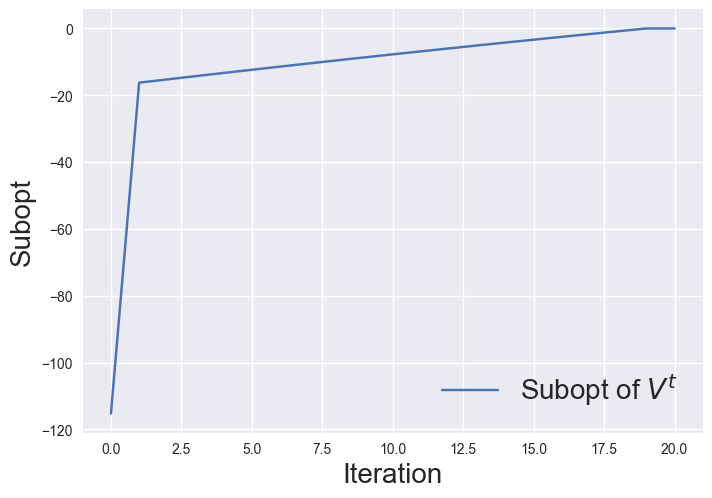

In [11]:
plot_lines(
    [compute_subopt(vs, solver.v)],
    [r"Subopt of $V^t$"],
    ["Iteration", "Subopt"],
    "figs",
    "VI.pdf",
    show=True,
)


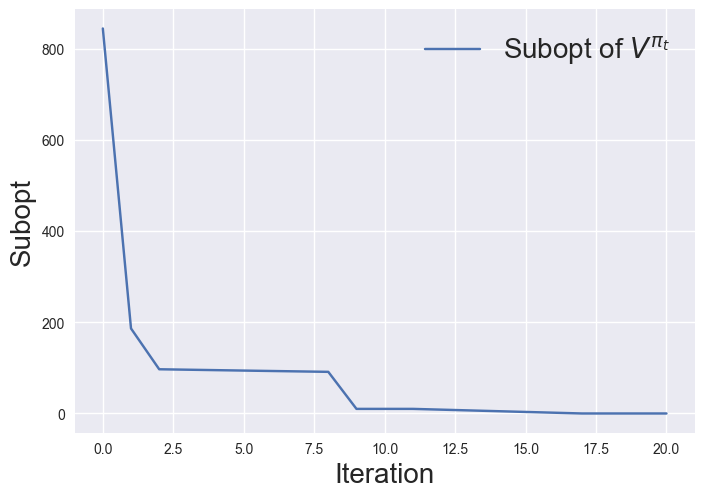

In [12]:
plot_lines(
    [compute_subopt(values, solver.v)],
    ["Subopt of $V^{\pi_t}$"],
    ["Iteration", "Subopt"],
    "figs",
    "VI.pdf",
    show=True,
)

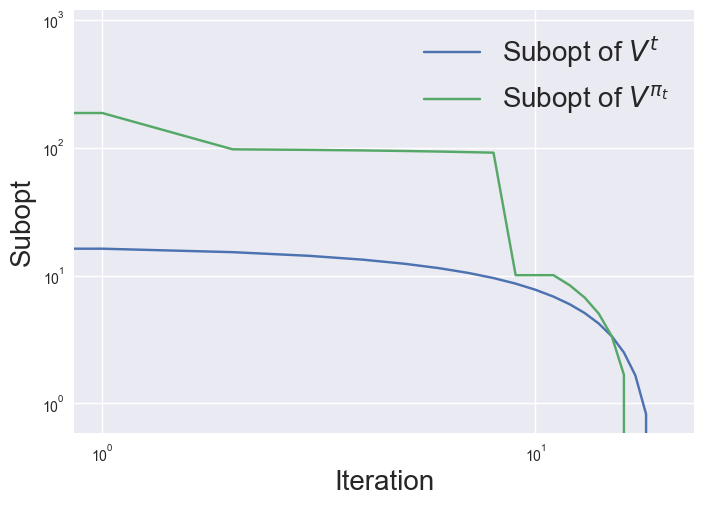

In [13]:
plot_log_lines(
    [-compute_subopt(vs, solver.v), compute_subopt(values, solver.v)],
    [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"],
    ["Iteration", "Subopt"],
    "figs",
    "VI.pdf",
    show=True,
)

To better appreciate the difference in the convergence plot use log scale.

**Question** : 
- Prove that $T$ is a contraction, that is $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$.
- Why the iterates of Value Iterations are an upper bound to $V^\star$ ? How is this possible considering that $V^\star \triangleq \max_{\pi \in \Pi} V^{\pi}$ ?

## **Answers**
##### **Proof** (like shown in the lecture)
For any $V', V \in \mathbb{R}^{|S|}$ and $s \in S$, we have:


$$
\left| (T V')(s) - (T V)(s) \right|
$$

$$
= \left| \max_{a \in A} \left[ r(s, a) + \gamma \sum_{s' \in S} P(s' | s, a) V'(s') \right] - \max_{a' \in A} \left[ r(s, a') + \gamma \sum_{s' \in S} P(s' | s, a') V(s') \right] \right|
$$

$$
\leq \max_{a \in A} \left( r(s, a) + \gamma \sum_{s' \in S} P(s' | s, a) V'(s') \right) - \left( r(s, a) + \gamma \sum_{s' \in S} P(s' | s, a) V(s') \right)
$$

$$
\leq \max_{a \in A} \gamma \sum_{s' \in S} P(s' | s, a) |V'(s') - V(s')|
$$
since V is independant of a we have that :
$$
\leq ||V' - V||_{\infty} \max_{a \in A} \gamma \sum_{s' \in S} P(s' | s, a) = \gamma ||V' - V||_{\infty}
$$

which concludes the proof.


##### Why Can Value Iteration Iterates Be An Upper Bound to $V^*$?

1. **$V^*$ is the Best Among All Policy-Based Values**  
   By definition, 
   $$
   V^*(s) = \max_{\pi} V^\pi(s),
   $$
   which means $V^*$ is the highest value function you can get if you **commit** to a single policy.

2. **Value Iteration Does Not Stick to a Single Policy**  
   During Value Iteration, each iteration picks the $\max_a$ **per state**, independently of the choices made in other states. This is different from a fixed policy, which uses **the same action** choice every time you revisit a state.

3. **Overestimations Occur**  
   Because Value Iteration always uses the $\max_a$ update, it can “pretend” it will do the best action in every future step, *even if* a single policy could never be that good in *all* states at once. As a result, $V_t(s)$ can be larger than $V^*(s)$ for some states.

4. **Convergence and Correction**  
   As the algorithm iterates, these “over-optimistic” values get corrected. Eventually, $V_t$ **converges from above** to the true optimal value $V^*$.

Hence there is **no contradiction** between:
- $V^* = \max_{\pi} V^\pi$ (the best *policy-based* value function), and
- $V_t \geq V^*$ (intermediate Value Iteration steps can exceed $V^*$).

They're talking about **two different ways** of estimating state values: 
- One is from *full policies*,(the policy determines the best (a1,a2,...,a_n) tuple overall since the start, and not 1 by 1) 
- the other is from *max-immediate-action updates at each iteration*.

**Value Iteration** uses that second approach until it finally settles on $V^*$, which *does* come from an optimal policy.


# Ex 2: Policy Iteration [25 pts.]

In [14]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            #reward = env.r[:, a]  # Get immediate rewards for all states taking action `a`
            # Transition probability matrix for action `a`
            P_a = env.sparseT[a].toarray()  # Shape: (n_states, n_states)
                
            q[:, a] = env.r[:, a] + env.gamma * P_a @ v #calculate Q-value
        for s in range(env.n_states):
            chosen_action = pi[s]
            v[s] = q[s, chosen_action]
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [15]:
def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = []
    for s in range(q.shape[0]):
        best_action = np.argmax(q[s])  # Choose the action with the highest Q-value
        policy.append(best_action)
    return policy

In [16]:
def policy_iteration(env, tol=1e-20):
    """Implementation of policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env,tol)
        pi = get_greedy_policy(q)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,pi

In [17]:
values_pi,_ = policy_iteration(gridworld)

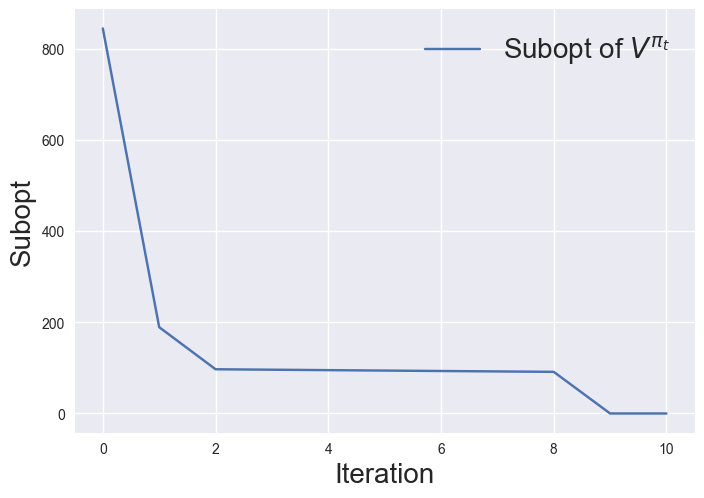

In [18]:
plot_lines(
    [compute_subopt(values_pi, solver.v)],
    ["Subopt of $V^{\pi_t}$"],
    ["Iteration", "Subopt"],
    "figs",
    "VI.pdf",
    show=True,
)

### Compare with Value Iteration

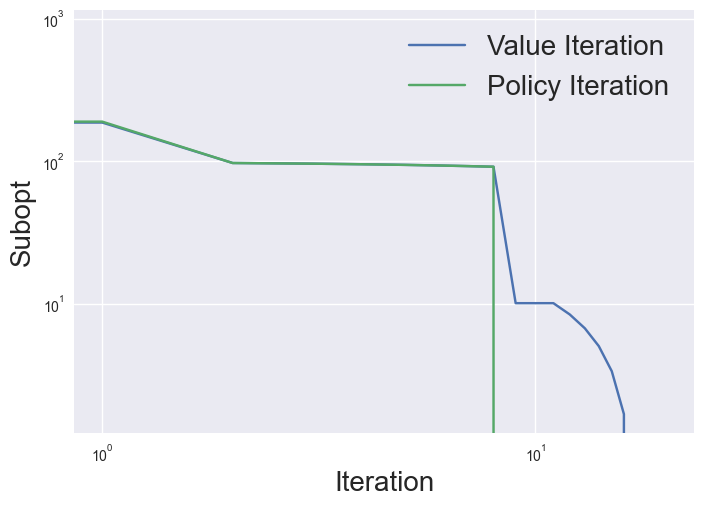

In [19]:
plot_log_lines(
    [compute_subopt(values, solver.v), compute_subopt(values_pi, solver.v)],
    ["Value Iteration", "Policy Iteration"],
    ["Iteration", "Subopt"],
    "figs",
    "VIvsPI.pdf",
    show=True,
)

***Questions :*** 
- Which algorithm converges faster ?
- Is it theoretically expected ? Answer listing the expected number of iterations needed for VI and PI to converge ?


***Answers***

- The policy iteration algorithm converges faster (9 iterations for PI, around 11 for VI)

- Although both algorithms may start from the same initial value function, Policy Iteration typically reaches the optimal policy in fewer iterations than Value Iteration. However, each iteration of Policy Iteration is more computationally expensive because it includes solving a system of linear equations during the policy evaluation step, whereas a single Value Iteration update is comparatively cheaper.
1. **Value Iteration**  
   - Converges within 
   $$
   \mathcal{O}\Bigl(\frac{\log\bigl(\epsilon (1-\gamma)\bigr)}{\log(\gamma)}\Bigr) 
   \;=\; \mathcal{O}\Bigl(5040\Bigr)
   $$

   iterations to achieve 
   $$ \|V_T - V^*\|_\infty \le \epsilon. $$
   - Each iteration applies the Bellman optimality operator once for every state.

2. **Policy Iteration**
   - Converges within 
   $$ 
   \mathcal{O}\!\Bigl(\frac{|S|(|A|-1)}{(1-\gamma)}\Bigr)
   \;=\; \mathcal{O}\Bigl(900\Bigr)
   $$ 
   - In practice, PI often needs **fewer total iterations** than VI, but each iteration may be more expensive.


***Theory Questions*** 
- Prove the policy improvement theorem.
- Prove that the Bellman operator is monotone elementwise. That is if $V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$.

***Answers***

## 1
- If a (deterministic) policy $\pi'$ satisfies that,

$$
Q^{\pi}(s, \pi'(s)) \geq V^{\pi}(s) \quad \forall s \in \mathcal{S},
$$

then $ V^{\pi'}(s) \geq V^{\pi}(s) $ for any $ s \in \mathcal{S} $.

 Proof:

For any $ s \in \mathcal{S} $, let $ s' \sim P(\cdot | s, \pi'(s)) $ denote the transition under policy $\pi'$:

$$
V^{\pi}(s) \leq Q^{\pi}(s, \pi'(s)) = \mathbb{E}_{\pi'} \left[ r(s_0, \pi'(s_0)) + \gamma V^{\pi}(s_1) \mid s_0 = s \right]
$$

Using the assumption,

$$
\leq \mathbb{E}_{\pi'} \left[ r_0 + \gamma r_1 + \gamma^2 r_2\pi'(s_1)) \mid s_0 = s \right]
$$
$$
\leq \mathbb{E}_{\pi'} \left[ r_0 + \gamma r_1 + \gamma V^{\pi}(s_1) \mid s_0 = s \right]
$$

Applying this recursively,

$$
\leq \mathbb{E}_{\pi'} \left[ r_0 + \gamma r_1 + \gamma^2 r_2 + \dots \mid s_0 = s \right] = V^{\pi'}(s)
$$

Thus, we have shown that $ V^{\pi'}(s) \geq V^{\pi}(s) $ for all $ s \in \mathcal{S} $, completing the proof.
## 2
- 1. **Definition of the Bellman operator under $\pi$:**

$$
(T_{\pi}V)(s) \;=\; r(s,\pi(s)) \;+\; \gamma \sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V(s').
$$

Similarly,

$$
(T_{\pi}V')(s) \;=\; r(s,\pi(s)) \;+\; \gamma \sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V'(s').
$$

2. **Assume $V \geq V'$ element-wise:**  

By hypothesis, for every state $s'$,
$$
V(s') \;\geq\; V'(s').
$$

3. **Apply probability weighting:**  

Since the transition probabilities $P(s' \mid s,\pi(s))$ are nonnegative and sum to 1,

$$
\sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V(s')
\;\ge\;
\sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V'(s').
$$

4. **Multiply by $\gamma$:**  

Because $0 \le \gamma < 1$, multiplying by $\gamma$ preserves the inequality:

$$
\gamma \sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V(s')
\;\ge\;
\gamma \sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V'(s').
$$

5. **Add $r(s,\pi(s))$ to both sides:**  

Adding the same immediate reward term $r(s,\pi(s))$ to both sides also preserves the inequality:

$$
r(s,\pi(s)) \;+\; \gamma \sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V(s')
\;\ge\;
r(s,\pi(s)) \;+\; \gamma \sum_{s'} P\bigl(s' \mid s,\pi(s)\bigr)\,V'(s').
$$

6. **Conclude the monotonicity:**  

Therefore,

$$
(T_{\pi}V)(s) \;\ge\; (T_{\pi}V')(s), \quad \forall s,
$$

which proves **monotonicity**: $T_{\pi}(V) \ge T_{\pi}(V')$ component-wise whenever $V \ge V'$.


# Ex 3: Modified Policy Iteration [25 pts.]

In this cell you will code and run Modified Value Iteration, that follows this pseudocode:
- $\pi_{k+1} = \mathcal{G}(V_k)$
- $V_{k+1} = T^m_{\pi_{k+1}}(V_k)$

In the implementation, we will use also the variable $Q$ as in the previous implementation of VI and PI for convenience of implementation.

**Questions**

Which value of $m$ recovers policy iteration ?
Which value of $m$ recovers value iteration ?

***Answers***

m=1 covers value iteration.
A large m, ideally until convergence to +inf recovers Policy Iteration.

First, write a function that applies the Bellman evaluation operator $m$ times

In [20]:
def policy_operator_m_times(pi, m, env, v, q):
    """Implementation of partial policy evaluation through applying m times the Bellman operator
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
        v: initial value vector
        q: initial state action value vector
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    i = 0
    while i < m:
        for a in range(env.n_actions):
            P_a = env.sparseT[a].toarray() # Shape: (n_states, n_states)
            q[:, a] = env.r[:, a] + env.gamma * P_a @ v
        for s in range(env.n_states):
            chosen_action = pi[s]
            v[s] = q[s, chosen_action]
        i = i + 1
    return v, q        

            

At this point, using the function `get_greedy_policy` implemented for PI you are ready to implement Modified Policy Iteration !

In [21]:
def modified_policy_iteration(env, m, tol=1e-10):
    """Implementation of modified policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        pi = get_greedy_policy(q)
        v, q = policy_operator_m_times(pi, m, env, v, q)
        policies.append(pi)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,policies

Now run modified policy iteration for different values of $m$ for example between $1$ and $10$. 

In [22]:
m_values = ["1", "2", "3", "5", "10", "20"]
to_plot = []
for m in m_values:
    m = int(m)
    _, policies_mpi = modified_policy_iteration(gridworld, m)
    values_mpi = evaluate_policy_sequence(policies_mpi, gridworld)
    to_plot.append(compute_subopt(values_mpi, solver.v))

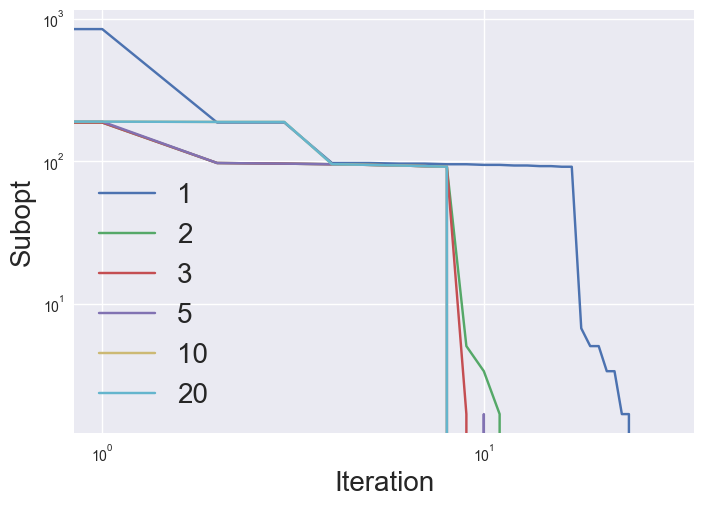

In [23]:
plot_log_lines(to_plot, m_values, ["Iteration", "Subopt"], "figs", "MPI.pdf", show=True)

**Questions** 
- How does the value of $m$ affect convergence ?
- Which is the cost per iteration of Modified Policy Iteration ?
- Which is the cost per iteration of Policy Iteration implemented with Option 2 in the slides ?

***Answers***

- Higher value of m result in faster convergence ( less iterations.)
---
## Step 1: Policy Improvement (Greedy Update)

- The policy update is:

  $$
  \pi_{k+1}(s) = \arg\max_a \left[ r(s, a) + \gamma \sum_{s'} P(s'|s,a) V_k(s') \right]
  $$

- This requires:
  - Computing $Q(s,a)$ for each state-action pair.
  - Taking the argmax over actions for each state.

### Computational Cost:
- $\mathcal{O}(|S| \cdot |A|)$ since for each state $s$, we compute $Q(s,a)$ for all $A$ actions.


## Step 2: Modified Policy Evaluation (Applying Bellman Operator $m$ Times)

- We update $V(s)$ using the Bellman operator $m$ times:

  $$
  V_{k+1} = \mathcal{T}_{\pi}^{m}(V_k)
  $$

- Each Bellman update involves:
  - Matrix-vector multiplication:
    $$
    V^\pi(s) = r(s, \pi(s)) + \gamma \sum_{s'} P(s' | s, \pi(s)) V(s').
    $$
  - Since the policy is fixed, each iteration effectively performs a sparse matrix-vector multiplication.

### Computational Cost:
- Each Bellman backup takes $\mathcal{O}(|S|^2)$ for a dense transition matrix but $\mathcal{O}(|S|)$ for a sparse transition matrix.
- Since we apply the operator $m$ times, the total cost is:
  - Dense Case: $\mathcal{O}(m |S|^2)$.
  - Sparse Case: $\mathcal{O}(m |S|)$.



## Total Cost per Iteration

Adding both steps together:

$$
\mathcal{O}(|S| \cdot |A|) + \mathcal{O}(m |S|^2) \quad \text{(Dense Case)}
$$

$$
\mathcal{O}(|S| \cdot |A|) + \mathcal{O}(m |S|) \quad \text{(Sparse Case)}
$$

- If $m = 1$ (Value Iteration-like), cost is close to $\mathcal{O}(|S| \cdot |A|)$.
- If $m$ is large (Modified Policy Iteration), cost approaches $\mathcal{O}(|S|^2)$ in dense settings.
---
## Step 1: Policy Evaluation

We need to compute $V^\pi$, which satisfies:

$$
V^\pi = (I - \gamma P^\pi)^{-1} R^\pi
$$

- **Matrix inversion dominates this step**:
  - The transition matrix $P^\pi$ has size $|S| \times |S|$.
  - Inverting this matrix takes **$\mathcal{O}(|S|^3)$** in the worst case (for a dense system).
  - If we use **iterative solvers** instead of direct inversion, it can be reduced, but typically remains around **$\mathcal{O}(|S|^3)$**.

Thus, **policy evaluation costs**:

$$
\mathcal{O}(|S|^3)
$$

## Step 2: Policy Improvement

Once we have $V^\pi$, we compute the action-value function $Q^\pi(s,a)$ and update the policy:

$$
Q^\pi(s,a) = r(s,a) + \gamma \sum_{s'} P(s'|s,a) V^\pi(s')
$$

- We must compute this for **each state-action pair** $(s,a)$.
- This requires:
  - $\mathcal{O}(|S|^2 |A|)$ operations, because for each **state-action pair**, we sum over all $S$ states.

Thus, **policy improvement costs**:

$$
\mathcal{O}(|S|^2 |A|)
$$

## Total Cost Per Iteration

Since each iteration consists of **Policy Evaluation + Policy Improvement**, the total per-iteration complexity is:

$$
\mathcal{O}(|S|^3 + |S|^2 |A|)
$$

- $\mathcal{O}(|S|^3)$ from solving for $V^\pi$.
- $\mathcal{O}(|S|^2 |A|)$ from computing $Q^\pi(s,a)$ and updating the policy.
resulting in a total cost of $\mathcal{O}(|S|^3 + |S|^2 |A|)$



# Ex 4: Q-Learning [15 pts.]

Now, we are ready to tackle the problem in the model free setting. For technical reason, we focus on the finite horizon setting in this part and we compare two exploration strategies.
1. **$\varepsilon$-greedy** (Watkins, Christopher John Cornish Hellaby. “Learning from Delayed Rewards.” PhD Thesis, King’s College, Cambridge United Kingdom, 1989.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Sample $b_h \sim \text{Bernoulli}(\varepsilon), \hat{a}_h \sim \text{Uniform}(\mathcal{A})$
      - Take action $a_h \leftarrow \left[(1-b_h) \left(\underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}\right) + b_h \hat{a}_h \right]$ and observe $x_{h+1}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha)Q_h(x_h,a_h) +\alpha\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1})\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$
2. **UCB bonuses** (Jin, Chi, Zeyuan Allen-Zhu, Sebastien Bubeck, and Michael I Jordan. “Is Q-Learning Provably Efficient?” In Advances in Neural Information Processing Systems, Vol. 31. Curran Associates, Inc., 2018. https://proceedings.neurips.cc/paper/2018/hash/d3b1fb02964aa64e257f9f26a31f72cf-Abstract.html.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ and $N_h(x,a) \leftarrow 0$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Take action $a_h \leftarrow \underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}$ and observe $x_{h+1}$
      - $t=N_h(x_h,a_h)\leftarrow N_h(x_h,a_h) + 1, \alpha_t = \frac{H+1}{H+t}$ and $b_t \leftarrow c\sqrt{\frac{H^3}{t}}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha_t)Q_h(x_h,a_h) +\alpha_t\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1}) + b_t\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$

For other technical reason, we also need to rescale the reward between 0 and 1, as done in the following

In [24]:
reward_mode = 0
size = 10
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

### Q learning with epsilon greedy 

In this subsection, we implement $Q$ Learning with the simplest possible exploration strategy: $\epsilon$-greedy.

In [25]:
def argmax_with_random_tie_breaking(b):
    return np.random.choice(np.where(b == b.max())[0])

In [26]:
def q_learning_epsilon_greedy(K: int = 100000, H: int = 20, epsilon: float = 0.1, alpha: float = 0.1) -> List[float]:
    """
    Function implementing the epsilon-greedy Q-learning algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param epsilon: Algorithm hyperparameter, exploration probability, float in [0, 1]
    :param alpha: Algorithm hyperparameter, Q update weight, float in [0, 1]

    :return: reward after each step, list of K * H floats
    """
    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            explore = np.random.binomial(2, p=epsilon)
            if explore:
                # Exploration: With probability epsilon take a random action
                a = np.random.choice(gridworld.n_actions)
            else:
                # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
                a = argmax_with_random_tie_breaking(Q[h, state, :])

            # Get reward for action
            rewards.append(gridworld.r[state, a])

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Update Q according to the algorithm
            Q[h, state, a] = (1-alpha)*Q[h, state, a] + alpha*(gridworld.r[state, a] + gridworld.gamma*V[h+1, new_state])

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.min([np.max(Q[h, state, :]), H])

            state = new_state
    return rewards

In [27]:
reward_eps_greedy = (
    q_learning_epsilon_greedy()
)  # You can play around with the arguments if you like
cumulative_reward_eps_greedy = np.cumsum(reward_eps_greedy)

### Q-Learning with bonuses

In this subsection, you are asked to implement an optimistic version of  Q Learning suggested in (Jin et al., 2018)

In [28]:
def q_learning_ucb_bonuses(K: int = 100000, H: int = 20, c: float = 0.0001) -> List[float]:
    """
    Function implementing the Q-learning with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param c: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0
    N = np.ones((H, gridworld.n_states, gridworld.n_actions))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # Take one of the optimal actions for the current state
            a = argmax_with_random_tie_breaking(Q[h, state, :])
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Calculate the UCB bonus
            bonus = c * np.sqrt(H ** 3 / N[h, state, a])

            # Calculate the adaptive alpha according to the algorithm
            alpha = (H + 1) / (H + N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = (1-alpha)*Q[h, state, a] + alpha*(gridworld.r[state, a] + V[h+1, new_state] + bonus)

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :])
            V[h, state] = np.clip(V[h, state], 0, H)

            state = new_state

    return rewards

In [29]:
reward_UCB = (
    q_learning_ucb_bonuses()
)  # You can play around with the arguments if you like
cumulative_reward_UCB = np.cumsum(reward_UCB)

### Comparison of exploration strategies

FileNotFoundError: [Errno 2] No such file or directory: '../plot/figsucbvseps.png'

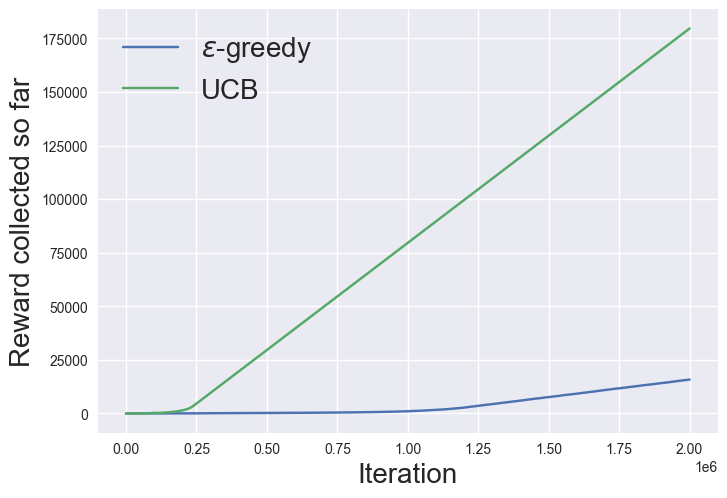

In [30]:
plot_lines(
    [cumulative_reward_eps_greedy, cumulative_reward_UCB],
    [r"$\epsilon$-greedy", "UCB"],
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=False,
)

**Question:** You are given an environment with $N$ states linked in a chain, i.e. from every state except the two endpoints there are two possible actions going right or go back to the first state in the chain. For the endpoints the second action is to stay in the same state. The reward is only 1 if you are in the rightmost state and stay there, otherwise 0. What is the probability that the $\varepsilon$-greedy algorithm will have a positive reward after $H$ steps in the first episode, if the chosen initial state is the leftmost state in the chain?

- If H < N , p=0 : the robot needs N-1 steps at least to reach point N(rightmost) and 1 additional step to re'stay' in N to acquire a positive reward, it needs at least N steps to acquire a positive reward

Since we have a 2 action scenario, we assume ,without loss of generality, that each action has a 0.5 = X probability of being chosen
- If H=N , only 1 path is possible to N which is go straight to goal from left to right (N-1 steps) and restay once on N : $p = (X) ^ N$
- If H=N+1, another path analysis taking into account the possibility of restaying in 1 , and restaying on N multiple times leads to : $p= 2*(X) ^ {N+1}$
- Further analysis of H = N+2 , H= N+3 , H= N+4 ( I spare you the details but with these you can even move right a few steps and reset to 1 which complicates the logic since you can restay on 1 either at the start or on the resets) shows that: $p= 2 ^ {H-N}*(X) ^ {H}$

**Question:** Does the empirical result match the theoretical result described in (Jin et al. 2018) ? Try to answer this question after reading their Appendix A and looking at their Table 1 for the algorithm they call UCB-H.

Based on the figure, UCB is collecting far more reward over time compared to  ε-greedy. 

This matches the theoretical results in Jin et al. (2018), where UCB-based Q-learning (UCB-H) is proven to have better sample complexity (lower regret) than plain ε-greedy Q-learning.

In other words, the green curve growing quickly in the plot aligns with the idea that UCB bonuses drive more efficient exploration, leading to faster learning and higher cumulative reward—exactly as the theory predicts.

## Monte Carlo (MC) and Time Differences (TD) ( * Question ) [25 points]

Disclaimer: The TA can not help you on this part of the notebook.

In [33]:

def generate_episode(policy: List, H: int, initial_state: int):
    """
    Generate an episode using the given policy.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param H: Maximum number of steps in the episode.
    :param initial_state: Starting state.

    :return: A list of (state, action, reward) tuples.
    """
    episode = []
    state = initial_state
    for _ in range(H):
        action = policy[state]
        reward = gridworld.r[state, action]
        next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Monte Carlo policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in range(K):  # Episode loop
        episode = generate_episode(policy, H, initial_state=99)  # Generate episode
        G = 0  # Return

        # Backward pass through the episode
        for t in range(len(episode) - 1, -1, -1):
            state, _, reward = episode[t]
            G = gamma * G + reward  # Discounted return

            # Update theta using gradient descent
            phi_s = phi[state]  # Feature vector for the current state
            V_hat = np.dot(theta, phi_s)  # Current value estimate
            theta += alpha * phi_s * (G - V_hat) 
            # Gradient descent update

    return theta


In [34]:

import numpy as np
def td_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Temporal Difference (TD) policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in range(K):  # Episode loop
        state = 99  # Initial state
        for _ in range(H):  # Step loop
            # Sample action from policy
            action = policy[state]
            reward = gridworld.r[state, action]
            next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])

            # Compute TD target and TD error
            phi_s = phi[state]  # Feature vector for current state
            phi_s_next = phi[next_state]  # Feature vector for next state
            V_s = np.dot(theta, phi_s)  # Current value estimate
            V_s_next = np.dot(theta, phi_s_next)  # Next value estimate
            td_target = reward + gamma * V_s_next
              # TD target
            td_error = td_target - V_s
              # TD error

            # Update theta using gradient descent
            theta += alpha*td_error*phi_s

            # Move to the next state
            state = next_state

    return theta

**Case 1:**

In [35]:
_, pi = policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(
    pi, phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1
)
theta_TD = td_policy_evaluation_with_linear_approx(
    pi, phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1
)

print(np.linalg.norm(theta_MC - theta_TD))

8.919948611419325e-07


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 1?
- Explain your answer writing down the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case. To give this answer you can assume that $\rho$ is positive everywhere.

-Yes, the solution does coincide in case 1 : we get 8.919948611419325e-07 as a result hch is basicly due to numerical errors.

---
#### Detailed Explanation

1.   
We have two ways to evaluate a policy $\pi$ in a Markov Decision Process (MDP) when the transition dynamics are unknown:

- Monte Carlo (MC) Policy Evaluation  
- Temporal Difference (TD) Learning

Both aim to estimate $V^\pi(s)$, the state-value function under policy $\pi$. Formally,
$$
V^\pi(s) = \mathbb{E}\biggl[\sum_{t=0}^{\infty}\gamma^t\,r(s_t, a_t)\,\Bigm|\;s_0 = s,\;\pi\biggr].
$$

#### **Monte Carlo (MC) Policy Evaluation**

**Key Idea**: Estimate $V^\pi(s)$ by sampling full returns from episodes.

1. **Generate an Episode**  
   - Begin in some initial state $s_0$.  
   - Follow $\pi$ for up to $H$ steps. Collect transitions $(s_t,a_t,r_t)$.

2. **Compute the Return**  
   - For each time $t$, define  
     $$
     G_t = \sum_{k=0}^{H-t-1}\gamma^k\,r_{t+k}.
     $$
   - $G_t$ is an **unbiased** sample of $V^\pi(s_t)$.

3. **Update the Value**  
   - For a visited state $s_t$, do
     $$
     V(s_t) \;\leftarrow\;V(s_t)\;+\;\alpha\bigl(G_t - V(s_t)\bigr).
     $$


#### **Temporal Difference (TD) Learning**  
**Key Idea**: Use a one-step bootstrap return $r_t + \gamma\,V(s_{t+1})$ instead of waiting for the entire episode.

1. **Collect Experience**  
   - Gather transitions $(s_t,a_t,r_t,s_{t+1})$ under $\pi$.

2. **One-Step TD Update**  
   - After each transition:
     $$
     V(s_t)\;\leftarrow\;V(s_t)\;+\;\alpha\bigl(r_t + \gamma\,V(s_{t+1}) - V(s_t)\bigr).
     $$

**Advantages and Limitations**  
- TD has **lower variance**, but is **slightly biased** (the target depends on the estimated $V$).  
- Updates occur **each step**, so it handles continuing environments easily.

#### **Analytical Solutions in the Linear Case**  
Suppose we approximate $V^\pi(s) \approx \phi(s)^\top \theta$.

- **Monte Carlo** solves a mean-squared error objective with respect to returns:
  $$
  \min_{\theta}\;\frac12 \sum_{s}\rho(s)\,\bigl(\phi(s)^\top\theta - V^\pi(s)\bigr)^2,
  $$
  which is the **projection** of $V^\pi$ onto the span of $\phi$.

- **TD(0)** solves a projected Bellman equation. If $\phi$ can represent $V^\pi$ exactly, both converge to the same solution. Otherwise, they can differ.

#### **Conclusion**  
- In **one-hot** (tabular) representation, **both Monte Carlo and TD(0) converge** to the true $V^\pi$ (numerically the same).  .  
- If function approximation is exact, they end up with the **same** final parameter vector for $V^\pi$.


**Case 2:**

In [36]:
_, pi = policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
phi[:50, :] *= 0

# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(
    pi, phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1
)
theta_TD = td_policy_evaluation_with_linear_approx(
    pi, phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1
)

print(np.linalg.norm(theta_MC - theta_TD))

190.43020836185028


**Answers**


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 2?
- Explain your answer leveraging the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case.

- The solutions here do not coincide (190.43020836185028 of difference)

---
phi[:50, :] *= 0
That line sets the first 50 rows of the one‐hot feature matrix 𝜙to zero. Concretely, for states 0 through 49, the feature vector becomes all zeros instead of a one‐hot vector. As a result, those states are no longer represented by their own features, so the linear function approximator cannot fit their values correctly (it has no way of distinguishing one state among those first 50).
We have a “defective” or “misspecified” representation in which some states have zeroed‐out features. Monte Carlo (MC) and TD learning converge to different solutions.